# Manufacturing Defect Analysis — Cleaned Notebook

#### Project title

### Manufacturing Defect Prediction & Repair Cost Estimation

### Objective:

##### Build a classification model to predict DefectStatus (binary) and interpret drivers (Logistic Regression).

##### Build a regression model to predict repair_cost (continuous) where appropriate.

##### Dataset: manufacturing_defect.csv. 

1. ### Setup & Imports

In [33]:
import sys
from pathlib import Path

# Add src folder to the Python path
sys.path.append(str(Path('../src').resolve()))

# Importing modules directly
from feature_engineering import drop_leaky_features, detect_leakage, split_X_y
from model_training import train_pipeline, evaluate, save_model, build_preprocessor, split_numeric_categorical
from model_evaluation import get_coefficients, get_feature_names, build_importance_df

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


# Modeling imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, r2_score


# Stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# Visual settings
sns.set(style='whitegrid')
%matplotlib inline

2. ### Load data

In [ ]:
df = pd.read_csv('../data/interim/cleaned_data.csv')
m_df = df.copy()

print('Shape:', m_df.shape)
m_df.head()

Shape: (3240, 17)


,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
0,202,13175.403783,86.648534,1,3.121492,63.463494,9,0.052343,8.630515,0.081322,85.042379,0,2419.616785,0.468947,5.551639,236.439301,1
1,535,19770.046093,86.310664,4,0.819531,83.697818,20,4.908328,9.296598,0.038486,99.657443,7,3915.566713,0.119485,9.080754,353.957631,1
2,960,19060.820997,82.132472,0,4.514504,90.350550,1,2.464923,5.097486,0.002887,92.819264,2,3392.385362,0.496392,6.562827,396.189402,1
3,370,5647.606037,87.335966,5,0.638524,67.628690,8,4.692476,3.577616,0.055331,96.887013,8,4652.400275,0.183125,8.097496,164.135870,1
4,206,7472.222236,81.989893,3,3.867784,82.728334,9,2.746726,6.851709,0.068047,88.315554,7,1581.630332,0.263507,6.406154,365.708964,1


: 

3. ### Quick EDA

In [ ]:
# Basic info
m_df.info()

# Descriptive stats
m_df.describe(include='all').T

# Check for missing values
m_df.isna().sum()

# Cardinality
m_df.nunique().sort_values(ascending=False)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3240 entries, 0 to 3239
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ProductionVolume      3240 non-null   int64  
 1   ProductionCost        3240 non-null   float64
 2   SupplierQuality       3240 non-null   float64
 3   DeliveryDelay         3240 non-null   int64  
 4   DefectRate            3240 non-null   float64
 5   QualityScore          3240 non-null   float64
 6   MaintenanceHours      3240 non-null   int64  
 7   DowntimePercentage    3240 non-null   float64
 8   InventoryTurnover     3240 non-null   float64
 9   StockoutRate          3240 non-null   float64
 10  WorkerProductivity    3240 non-null   float64
 11  SafetyIncidents       3240 non-null   int64  
 12  EnergyConsumption     3240 non-null   float64
 13  EnergyEfficiency      3240 non-null   float64
 14  AdditiveProcessTime   3240 non-null   float64
 15  AdditiveMaterialCost 

ProductionCost          3240
AdditiveMaterialCost    3240
SupplierQuality         3240
DefectRate              3240
QualityScore            3240
InventoryTurnover       3240
DowntimePercentage      3240
WorkerProductivity      3240
StockoutRate            3240
EnergyConsumption       3240
AdditiveProcessTime     3240
EnergyEfficiency        3240
ProductionVolume         862
MaintenanceHours          24
SafetyIncidents           10
DeliveryDelay              6
DefectStatus               2
dtype: int64

: 

```
** Notes: **

* Identify which columns are numeric vs categorical.
* If date columns exist, convert to datetime and extract features (month, day, weekday).

```

In [ ]:
# Example date handling
if 'DefectDate' in m_df.columns:
    m_df['DefectDate'] = pd.to_datetime(m_df['defect_date'], errors='coerce')
    m_df['DefectMonth'] = m_df['defect_date'].dt.month
    m_df['DefectWeekday'] = m_df['defect_date'].dt.weekday
    # drop the raw date if not needed
    m_df = m_df.drop(columns=['defect_date'])

: 

4. #### checking for multicolinearity

<Axes: >

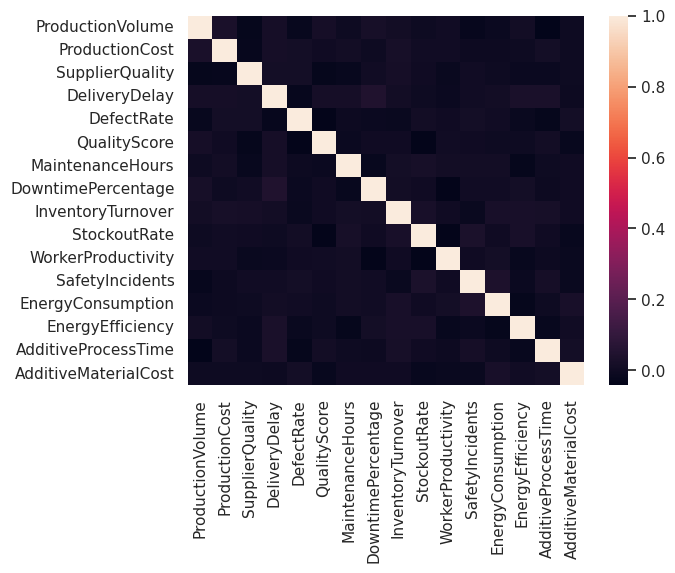

: 

In [ ]:
correlation = m_df.select_dtypes('number').drop(columns='DefectStatus').corr()

# plot heatmap
sns.heatmap(correlation)

#### Seems we where unable to detect any multicolinearity in our heatmap above

### 5.  Leak detection and feature selections

In [ ]:
# If a column perfectly determines it target, it is leaky(we will drop it)

leaky_cols = detect_leakage(df, 'DefectStatus')
print("Potential leaky columns:", leaky_cols)

print(m_df[leaky_cols].corr())

# categorical or discrete leaks that correlation won’t detect: this is a post production features

# Defect rate against defect status
print((m_df.groupby("DefectRate")["DefectStatus"].nunique() == 1).all())

# Quality Score agains defect status
print((m_df.groupby("QualityScore")["DefectStatus"].nunique() == 1).all())

# checking for indirect leakage
print(m_df.corr()["DefectStatus"].sort_values(ascending=False))




Potential leaky columns: []
Empty DataFrame
Columns: []
Index: []
True
True
DefectStatus            1.000000
MaintenanceHours        0.297107
DefectRate              0.245746
ProductionVolume        0.128973
StockoutRate            0.040574
SupplierQuality         0.038184
ProductionCost          0.026720
InventoryTurnover       0.006733
AdditiveProcessTime     0.005619
DeliveryDelay           0.005425
EnergyConsumption       0.005039
DowntimePercentage      0.004128
AdditiveMaterialCost   -0.000953
WorkerProductivity     -0.005224
SafetyIncidents        -0.016039
EnergyEfficiency       -0.035031
QualityScore           -0.199219
Name: DefectStatus, dtype: float64


: 

In [ ]:
# we will be droping QualityScore, DefectRate, as they have shown to be leaky features
leaky_cols = ["QualityScore",  "DefectRate"]
m_df = drop_leaky_features(m_df, leaky_cols)

Dropping leaky column: QualityScore
Dropping leaky column: DefectRate


: 

### 6. Prepare features: split into X, y then train/ test

In [ ]:
classification_target = 'DefectStatus'

# Drop Id column if exists
drop_cols = [c for c in ['defect_id'] if c in m_df.columns]

# Drop those columns from the dataframe
m_df = m_df.drop(columns=drop_cols)

# Split into X and y
X, y = split_X_y(m_df, classification_target)

# sanity
print("Features used: ", X.shape[1])
print("Sample: ", X.shape[0])


# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Features used:  14
Sample:  3240


: 

### 7. Identify numeric and categorical columns

In [ ]:
numeric_cols, cat_cols = split_numeric_categorical(X)


Original Numeric: ['ProductionVolume', 'ProductionCost', 'SupplierQuality', 'DeliveryDelay', 'MaintenanceHours', 'DowntimePercentage', 'InventoryTurnover', 'StockoutRate', 'WorkerProductivity', 'SafetyIncidents', 'EnergyConsumption', 'EnergyEfficiency', 'AdditiveProcessTime', 'AdditiveMaterialCost']
Original Categorical: []

Adjusted Numeric: ['ProductionVolume', 'ProductionCost', 'SupplierQuality', 'MaintenanceHours', 'DowntimePercentage', 'InventoryTurnover', 'StockoutRate', 'WorkerProductivity', 'EnergyConsumption', 'EnergyEfficiency', 'AdditiveProcessTime', 'AdditiveMaterialCost']
Adjusted Categorical: ['DeliveryDelay', 'SafetyIncidents']


: 

### 8. Build Preprocessing pipeline


In [ ]:

preprocessor = build_preprocessor(X, numeric_cols=numeric_cols, cat_cols=cat_cols)

: 

### 9 Logistic Regression (Classification)

[INFO] Training LogisticRegression (classification) pipeline...
[INFO] LogisticRegression training complete.
[INFO] Detected model type: classification
[INFO] Evaluating model performance...
[INFO] Training Accuracy: 0.690
[INFO] Test Accuracy: 0.685



Training Accuracy: 0.690
Test Accuracy: 0.685

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.65      0.40       103
           1       0.91      0.69      0.79       545

    accuracy                           0.69       648
   macro avg       0.60      0.67      0.59       648
weighted avg       0.81      0.69      0.72       648



[INFO] Evaluation figure saved to ../reports/figures/model_evaluation.png


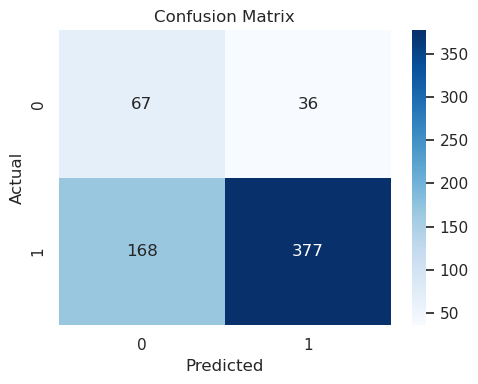

: 

In [ ]:


clf_model = train_pipeline(X_train, y_train, preprocessor, model_type='classification', model=LogisticRegression(
    max_iter=3000, class_weight='balanced', random_state=42,  C=0.2, solver='liblinear')
)

# Evaluate
evaluate(clf_model, X_train, y_train, X_test, y_test, fig_out='../reports/figures/model_evaluation.png', show_plot=True)


### 10. Features names & coefficients -> importance & odds ratio

In [ ]:
# Get Transformed feature names
from model_evaluation import get_coefficients, get_feature_names


feature_names = get_feature_names(clf_model)
coefs = get_coefficients(clf_model)

importance = build_importance_df(pipe=clf_model, X_train=X_train)

importance['Odds_Ratio'] = np.exp(importance['Coefficient'])

#  Sort by magnitude or odds ratio
importance = importance.sort_values(by='Odds_Ratio', ascending=True).reset_index(drop=True)
# print(importance)

# set index for plotting
importance.set_index('Feature', inplace=True)
importance.head()

,Coefficient,Odds_Ratio
Feature,,
cat__DeliveryDelay_2,-0.175424,0.839101
cat__SafetyIncidents_9,-0.125856,0.881742
num__EnergyEfficiency,-0.082121,0.921160
cat__SafetyIncidents_6,-0.076521,0.926334
cat__SafetyIncidents_2,-0.054018,0.947415


: 

#### plot odds Ratio


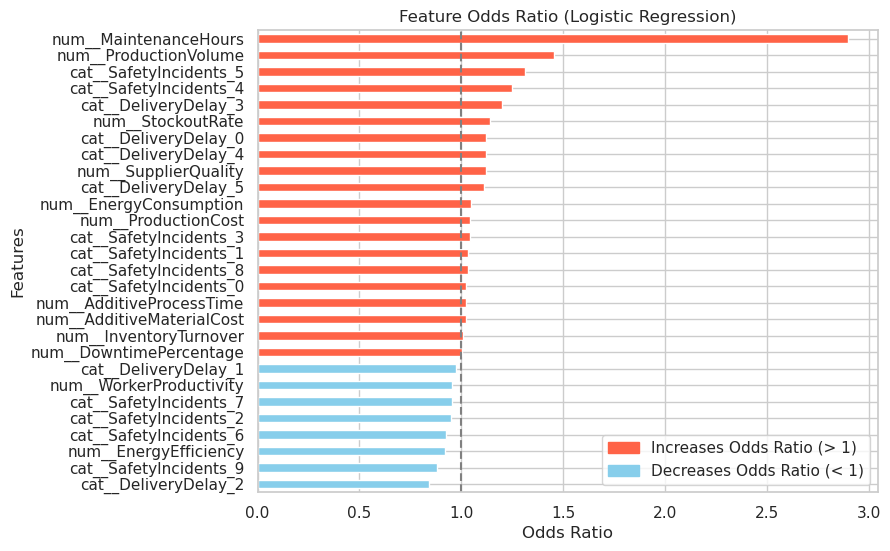

: 

In [ ]:
plt.figure(figsize=(8, 6))
colors = ['tomato' if x > 1 else 'skyblue' for x in importance['Odds_Ratio']]
importance['Odds_Ratio'].plot(kind='barh', color=colors)
plt.axvline(x=1, color='gray', linestyle='--', label='Odds Ratio = 1')
red_papatch = mpatches.Patch(color='tomato', label='Increases Odds Ratio (> 1)')
blue_patch = mpatches.Patch(color='skyblue', label='Decreases Odds Ratio (< 1)')
plt.legend(handles=[red_papatch, blue_patch], loc='lower right')
plt.xlabel('Odds Ratio')
plt.ylabel('Features')
plt.title('Feature Odds Ratio (Logistic Regression)')
plt.show()

### 11. Model Comparison & Cross-Validation

In [ ]:
# Compare Logistic Regression with Random Forest
rfc_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])

for name, model in [('Logistic Regression', clf_model), ('Random Forest', rfc_model)]:
    print(f"Evaluating {name}")
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(name, "CV Accuracy Mean: ", round(scores.mean(), 4))
    print(name, "CV Accuracy Std: ", round(scores.std(), 4))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

Evaluating Logistic Regression
Logistic Regression CV Accuracy Mean:  0.6833
Logistic Regression CV Accuracy Std:  0.0216
              precision    recall  f1-score   support

           0       0.28      0.64      0.39       103
           1       0.91      0.69      0.79       545

    accuracy                           0.68       648
   macro avg       0.60      0.67      0.59       648
weighted avg       0.81      0.68      0.72       648

[[ 66  37]
 [168 377]]
Evaluating Random Forest
Random Forest CV Accuracy Mean:  0.8367
Random Forest CV Accuracy Std:  0.0087
              precision    recall  f1-score   support

           0       0.25      0.02      0.04       103
           1       0.84      0.99      0.91       545

    accuracy                           0.83       648
   macro avg       0.55      0.50      0.47       648
weighted avg       0.75      0.83      0.77       648

[[  2 101]
 [  6 539]]


: 

### Save Models and Conclusion

In [ ]:
# save models


clf_model_path = '../models/logistic_regression_model.joblib'
rfc_model_path = '../models/random_forest_model.joblib'
save_model(clf_model, clf_model_path)
save_model(rfc_model, rfc_model_path)



[INFO] Model saved to: ../models/logistic_regression_model.joblib
[INFO] Model saved to: ../models/random_forest_model.joblib


## Conclusion

This project compared **Logistic Regression** and **Random Forest Classifier** for defect prediction. Logistic Regression showed strong generalization with 84% test accuracy and better interpretability, while Random Forest achieved higher cross-validation accuracy (83.5%) but with increased complexity.

Despite both models performing well, Logistic Regression is recommended for deployment due to its balance of accuracy, transparency, and efficiency. Random Forest may serve as a benchmark for performance-focused scenarios.

### Recommendations

- Tune hyperparameters for both models.
- Apply class balancing techniques (e.g., SMOTE).
- Validate with new/unseen data.
- Analyze feature importance for deeper insights.